# Bragg-edge imaging with ODIN

This notebook illustrates how to convert recorded events on the ODIN detector to a single wavelength spectrum,
revealing a Bragg edge in the data.
WFM mode was used in the chopper cascade.

In [1]:
import scipp as sc
from ess.reduce import time_of_flight
from ess import odin
import ess.odin.data  # noqa: F401
from ess.imaging.types import *

## Create and configure the workflow

In [2]:
wf = odin.OdinBraggEdgeWorkflow()

wf[Filename[SampleRun]] = odin.data.iron_simulation_sample_small()
wf[NeXusDetectorName] = "event_mode_detectors/timepix3"
wf[time_of_flight.TimeOfFlightLookupTableFilename] = odin.data.odin_tof_lookup_table()

## First look at the data

We load the raw detector data and perform a quick visualization of the `event_time_offset` spectrum.

In [3]:
tmpx3 = wf.compute(RawDetector[SampleRun])
tmpx3

<scipp.DataArray>
Dimensions: Sizes[dim_0:1024, dim_1:1024, ]
Coordinates:
* detector_number             int32        <no unit>  (dim_0, dim_1)  [1, 2, ..., 1048575, 1048576]
* position                  vector3              [m]  (dim_0, dim_1)  [(-0.007033, 0.007033, 0), (-0.007019, 0.007033, 0), ..., (0.007019, -0.007033, 0), (0.007033, -0.007033, 0)]
* x_pixel_offset            float32              [m]  (dim_0, dim_1)  [-0.007033, -0.007019, ..., 0.007019, 0.007033]
* y_pixel_offset            float32              [m]  (dim_0, dim_1)  [0.007033, 0.007033, ..., -0.007033, -0.007033]
Data:
                          DataArrayView        <no unit>  (dim_0, dim_1)  binned data: dim='event', content=DataArray(
          dims=(event: 1000000),
          data=float32[counts],
          coords={'event_time_offset':float64[ns], 'event_time_zero':datetime64[ns]})

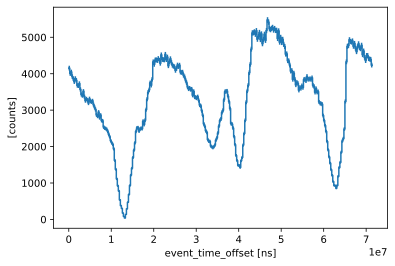

In [4]:
tmpx3.bins.concat().hist(event_time_offset=300).plot()

## Compute neutron time-of-flight/wavelength

We will now use the workflow to compute the neutron time-of-flight (equivalent to wavelength) using a lookup table built from the beamline chopper information.

In [5]:
wf.visualize(TofDetector[SampleRun], graph_attr={"rankdir": "LR"})

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

### Inspect the lookup table

It is always a good idea to quickly plot the TOF lookup table, as a sanity check.

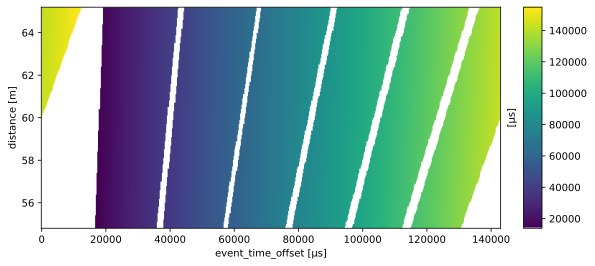

In [6]:
table = wf.compute(time_of_flight.TimeOfFlightLookupTable)
table.plot(figsize=(9, 4))

### Compute neutron wavelengths

In [7]:
sample_wavs = wf.compute(WavelengthDetector[SampleRun])

sample_wavs.bins.concat().hist(wavelength=300).plot()

UnsatisfiedRequirement: Missing input node 'LookupTableRelativeErrorThreshold'. Affects requested targets (via providers given in parentheses):
1. LookupTableRelativeErrorThreshold → (ess.reduce.time_of_flight.eto_to_tof.mask_large_uncertainty_in_lut_detector) → ErrorLimitedTofLookupTable[NXdetector] → (ess.reduce.time_of_flight.eto_to_tof.detector_time_of_flight_data) → TofDetector[SampleRun] → (ess.imaging.conversion.compute_detector_wavelength) → WavelengthDetector[SampleRun]



## Process the open-beam run

We now reuse the same workflow to process the open-beam run that will be used later for normalization.

In [8]:
wf[Filename[OpenBeamRun]] = odin.data.iron_simulation_ob_small()
openbeam_wavs = wf.compute(WavelengthDetector[OpenBeamRun])

openbeam_wavs.bins.concat().hist(wavelength=300).plot()

UnsatisfiedRequirement: Missing input node 'LookupTableRelativeErrorThreshold'. Affects requested targets (via providers given in parentheses):
1. LookupTableRelativeErrorThreshold → (ess.reduce.time_of_flight.eto_to_tof.mask_large_uncertainty_in_lut_detector) → ErrorLimitedTofLookupTable[NXdetector] → (ess.reduce.time_of_flight.eto_to_tof.detector_time_of_flight_data) → TofDetector[OpenBeamRun] → (ess.imaging.conversion.compute_detector_wavelength) → WavelengthDetector[OpenBeamRun]



## Select region of interest by masking outer regions

Making a 2D histogram of the data shows a dark square region in the centre of the detector panel;
this is the region of interest, where the square sample has absorbed neutrons.

In [9]:
sample_wavs.hist().plot(aspect='equal')

NameError: name 'sample_wavs' is not defined

The brighter areas around the edges are regions where neutrons did not travel through the sample.
We thus want to mask those out using masking rules based on the spatial coordinates of the data:

In [10]:
wf[MaskingRules] = {
    'x_pixel_offset': lambda x: (x < sc.scalar(-5.8e-3, unit='m').to(unit=x.unit)) | (x > sc.scalar(5.8e-3, unit='m').to(unit=x.unit)),
    'y_pixel_offset': lambda y: (y < sc.scalar(-5.8e-3, unit='m').to(unit=y.unit)) | (y > sc.scalar(5.8e-3, unit='m').to(unit=y.unit))
}

In [11]:
masked = wf.compute(CorrectedDetector[SampleRun])

masked.hist().plot(aspect='equal')

UnsatisfiedRequirement: Missing input node 'LookupTableRelativeErrorThreshold'. Affects requested targets (via providers given in parentheses):
1. LookupTableRelativeErrorThreshold → (ess.reduce.time_of_flight.eto_to_tof.mask_large_uncertainty_in_lut_detector) → ErrorLimitedTofLookupTable[NXdetector] → (ess.reduce.time_of_flight.eto_to_tof.detector_time_of_flight_data) → TofDetector[SampleRun] → (ess.imaging.conversion.compute_detector_wavelength) → WavelengthDetector[SampleRun] → (ess.odin.masking.apply_masks) → CorrectedDetector[SampleRun]



## Normalize to open beam

Finally, we use the masked sample and open-beam data to obtain a normalized signal,
which reveals the Fe Bragg edges:

In [12]:
wbins = sc.linspace('wavelength', 1.1, 9.4, 301, unit='angstrom')

normalized = (
        wf.compute(CorrectedDetector[SampleRun]).bins.concat().hist(wavelength=wbins) /
        wf.compute(CorrectedDetector[OpenBeamRun]).bins.concat().hist(wavelength=wbins)
)

normalized.plot()

UnsatisfiedRequirement: Missing input node 'LookupTableRelativeErrorThreshold'. Affects requested targets (via providers given in parentheses):
1. LookupTableRelativeErrorThreshold → (ess.reduce.time_of_flight.eto_to_tof.mask_large_uncertainty_in_lut_detector) → ErrorLimitedTofLookupTable[NXdetector] → (ess.reduce.time_of_flight.eto_to_tof.detector_time_of_flight_data) → TofDetector[SampleRun] → (ess.imaging.conversion.compute_detector_wavelength) → WavelengthDetector[SampleRun] → (ess.odin.masking.apply_masks) → CorrectedDetector[SampleRun]



## Save the final result

In [13]:
from scippneutron.io import save_xye

to_disk = normalized.copy(deep=False)
to_disk.coords['wavelength'] = sc.midpoints(to_disk.coords['wavelength'])

save_xye('fe_bragg_edge.xye', to_disk)

NameError: name 'normalized' is not defined